In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [3]:
data = pd.read_csv("tech_layoffs_Q2_2024.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   #                            1839 non-null   int64  
 1   Company                      1839 non-null   object 
 2   Location_HQ                  1839 non-null   object 
 3   Region                       473 non-null    object 
 4   State                        566 non-null    object 
 5   Country                      1839 non-null   object 
 6   Continent                    1839 non-null   object 
 7   Laid_Off                     1677 non-null   float64
 8   Date_layoffs                 1839 non-null   object 
 9   Percentage                   1667 non-null   object 
 10  Company_Size_before_Layoffs  1585 non-null   object 
 11  Company_Size_after_layoffs   1619 non-null   object 
 12  Industry                     1839 non-null   object 
 13  Stage             

In [5]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()

  df.columns = df.columns.str.strip().str.replace('-','_').str.replace('__','_')

  if '#' in df.columns:
    df = df.rename(columns={'#':'id'})

  df['Percentage'] = df['Percentage'].astype(str).str.strip().str.replace(',','.',regex=False)
  df['Percentage'] = pd.to_numeric(df['Percentage'],errors='coerce')

  df['Date_layoffs'] = pd.to_datetime(df['Date_layoffs'],errors='coerce')

  for col in ['Company_Size_before_Layoffs','Company_Size_after_layoffs']:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].replace('',np.nan)
    df[col] = pd.to_numeric(df[col],errors='coerce')

  num_cols = [
        "Laid_Off",
        "Percentage",
        "Company_Size_before_Layoffs",
        "Company_Size_after_layoffs",
        "Money_Raised_in__mil"
    ]

  for col in num_cols:
    if col in df.columns:
      df[col] = df[col].fillna(df[col].median())

  cat_cols = ["Region", "State", "Industry", "Stage",
                "Location_HQ", "Country", "Continent"]

  for col in cat_cols:
    if col in df.columns:
      df[col] = df[col].fillna("Unknown")

  df["Year_of_layoff"] = df["Date_layoffs"].dt.year
  df["Month"] = df["Date_layoffs"].dt.month
  df["Day"] = df["Date_layoffs"].dt.day

  return df

In [6]:
df = clean_data(data)

In [7]:
# Feature Engineering

df["Size_Diff"] = df["Company_Size_before_Layoffs"] - df["Company_Size_after_layoffs"]

df["Size_Ratio"] = df["Company_Size_after_layoffs"] / (df["Company_Size_before_Layoffs"] + 1e-6)

df["Funding_per_Employee"] = df["Money_Raised_in_mil"] / (df["Company_Size_before_Layoffs"] + 1e-6)

df["Is_USA"] = (df["Country"] == "USA").astype(int)

high_risk_industries = ["Tech","Technology","Fintech",'Retail','E-Commerce']
df['Is_High_Risk_Industry'] = df['Industry'].isin(high_risk_industries).astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           1839 non-null   int64         
 1   Company                      1839 non-null   object        
 2   Location_HQ                  1839 non-null   object        
 3   Region                       1839 non-null   object        
 4   State                        1839 non-null   object        
 5   Country                      1839 non-null   object        
 6   Continent                    1839 non-null   object        
 7   Laid_Off                     1839 non-null   float64       
 8   Date_layoffs                 1839 non-null   datetime64[ns]
 9   Percentage                   1839 non-null   float64       
 10  Company_Size_before_Layoffs  1839 non-null   float64       
 11  Company_Size_after_layoffs   1839 non-null 

In [9]:
target = 'Laid_Off'
feature_cols = ['Percentage','Company_Size_before_Layoffs','Company_Size_after_layoffs','Money_Raised_in_mil',
                'Year','latitude','longitude','Year_of_layoff','Month','Day','Size_Diff','Size_Ratio',
                'Funding_per_Employee','Is_USA','Is_High_Risk_Industry']
cat_cols = ['Company','Industry','Stage']

X = df[feature_cols + cat_cols]
y = df[target]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=43)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [10]:
cat_feature_indices = [X.columns.get_loc(col) for col in cat_cols]

model = CatBoostRegressor(
    iterations=700,
    depth=7,
    learning_rate=0.05,
    loss_function="RMSE",
    random_seed=43,
    verbose=True
)

model.fit(
    X_train,
    y_train_log,
    cat_features = cat_feature_indices
)

0:	learn: 1.1909011	total: 68.7ms	remaining: 48s
1:	learn: 1.1531484	total: 86ms	remaining: 30s
2:	learn: 1.1149491	total: 112ms	remaining: 26s
3:	learn: 1.0776392	total: 131ms	remaining: 22.8s
4:	learn: 1.0398171	total: 149ms	remaining: 20.7s
5:	learn: 1.0041467	total: 182ms	remaining: 21s
6:	learn: 0.9714416	total: 209ms	remaining: 20.7s
7:	learn: 0.9415458	total: 221ms	remaining: 19.1s
8:	learn: 0.9114844	total: 243ms	remaining: 18.7s
9:	learn: 0.8846499	total: 253ms	remaining: 17.5s
10:	learn: 0.8569545	total: 280ms	remaining: 17.5s
11:	learn: 0.8345681	total: 301ms	remaining: 17.2s
12:	learn: 0.8140761	total: 312ms	remaining: 16.5s
13:	learn: 0.7923143	total: 324ms	remaining: 15.9s
14:	learn: 0.7716809	total: 337ms	remaining: 15.4s
15:	learn: 0.7518157	total: 390ms	remaining: 16.7s
16:	learn: 0.7323646	total: 407ms	remaining: 16.4s
17:	learn: 0.7142261	total: 430ms	remaining: 16.3s
18:	learn: 0.6976350	total: 459ms	remaining: 16.4s
19:	learn: 0.6815454	total: 478ms	remaining: 16.3

In [11]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

In [12]:
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)

# in case y_test == 0
mask = y_test != 0
mape = mean_absolute_percentage_error(y_test[mask],y_pred[mask]) * 100

print("Mean Absolute Error : ",mae)
print("Root Mean Square Error : ",rmse)
print("Mean Absolute Percentage Error : ",mape,"%")
print("Accuracy : ",100 - mape,"%")

Mean Absolute Error :  53.17842561796218
Root Mean Square Error :  340.76285658963445
Mean Absolute Percentage Error :  14.231855317771073 %
Accuracy :  85.76814468222892 %


,Feature Id,Importances
0,Size_Diff,66.568008
1,Company_Size_before_Layoffs,4.370013
2,Industry,3.379917
3,Stage,3.166104
4,Funding_per_Employee,3.120740
5,Money_Raised_in_mil,2.606194
6,Company,2.519977
7,Year,1.862088
8,Percentage,1.835503
9,latitude,1.828876


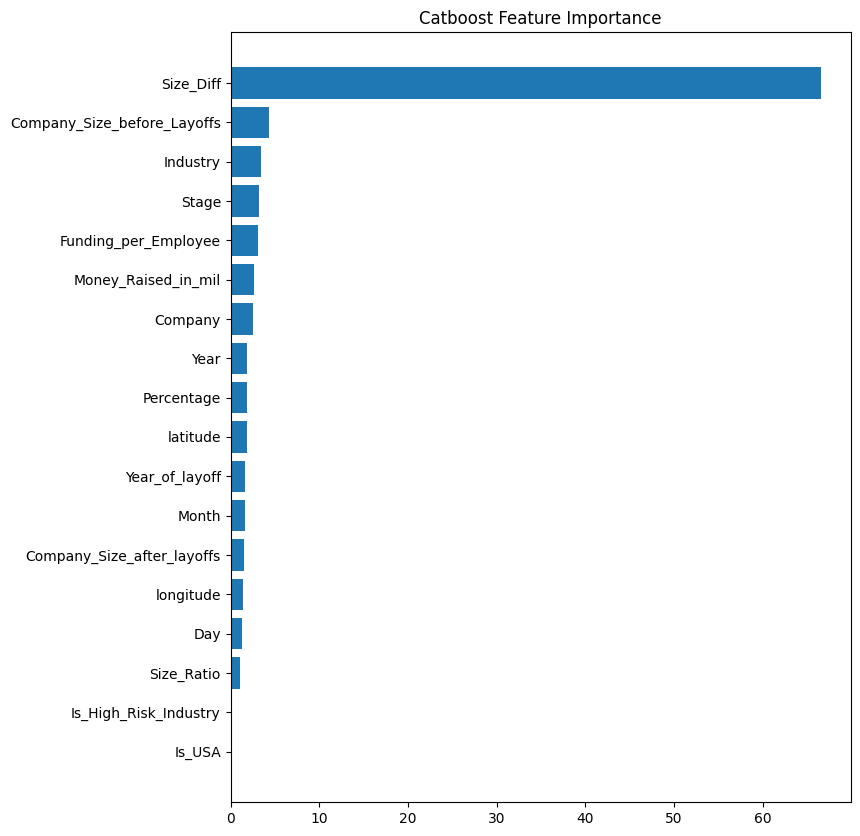

In [18]:
import matplotlib.pyplot as plt

feat_importances = model.get_feature_importance(prettified=True)
display(feat_importances)

plt.figure(figsize=(8,10))
plt.barh(feat_importances['Feature Id'],feat_importances['Importances'])
plt.gca().invert_yaxis()
plt.title('Catboost Feature Importance')
plt.show()